In [1]:
%matplotlib inline
from IPython.display import HTML, display

HTML('''<script>
code_show=false; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
''')

In [2]:
from matplotlib import pyplot as plt
#plt.rcParams["figure.figsize"] = (10,5)
#import seaborn as sns
#sns.set()

import torch

import numpy as np
from cassie import CassieEnv

from rl.policies import GaussianMLP
from rl.envs import normalize

env = CassieEnv("walking", clock_based=True)
traj = env.trajectory

policy = torch.load("XieNew.pt")

policy.training = False

In [3]:
from collections import defaultdict

@torch.no_grad()
def get_trajectory_data(trj_len):
    data = defaultdict(lambda: [])
    
    state = torch.Tensor(env.reset())
    for t in range(trj_len):
        v, action = policy.act(state, True)
        v, action = v.numpy(), action.numpy()
        
        next_state, reward, done, _ = env.step(action)
        
        data["qpos"]    += [np.copy(env.sim.qpos())]
        data["qvel"]    += [np.copy(env.sim.qvel())]
        
        data["u_ref"]   += [env.get_ref_state(env.phase)[0][env.pos_idx]]
        
        data["u_delta"] += [action]
        
        data["s"]       += [next_state]
        
        data["reward"]  += [reward]
        
        forces = np.zeros((12))
        env.sim.foot_force(forces)
        
        data["ff_left"]  += [forces[2]]
        data["ff_right"] += [forces[8]]
        
        if done:
           print("Warning: hit terminal state at step {}".format(t))
           break
            
        state = torch.Tensor(next_state)

    data = dict((k, np.array(v)) for k,v in data.items())

    return data


Time varying trajectory for one full phase.

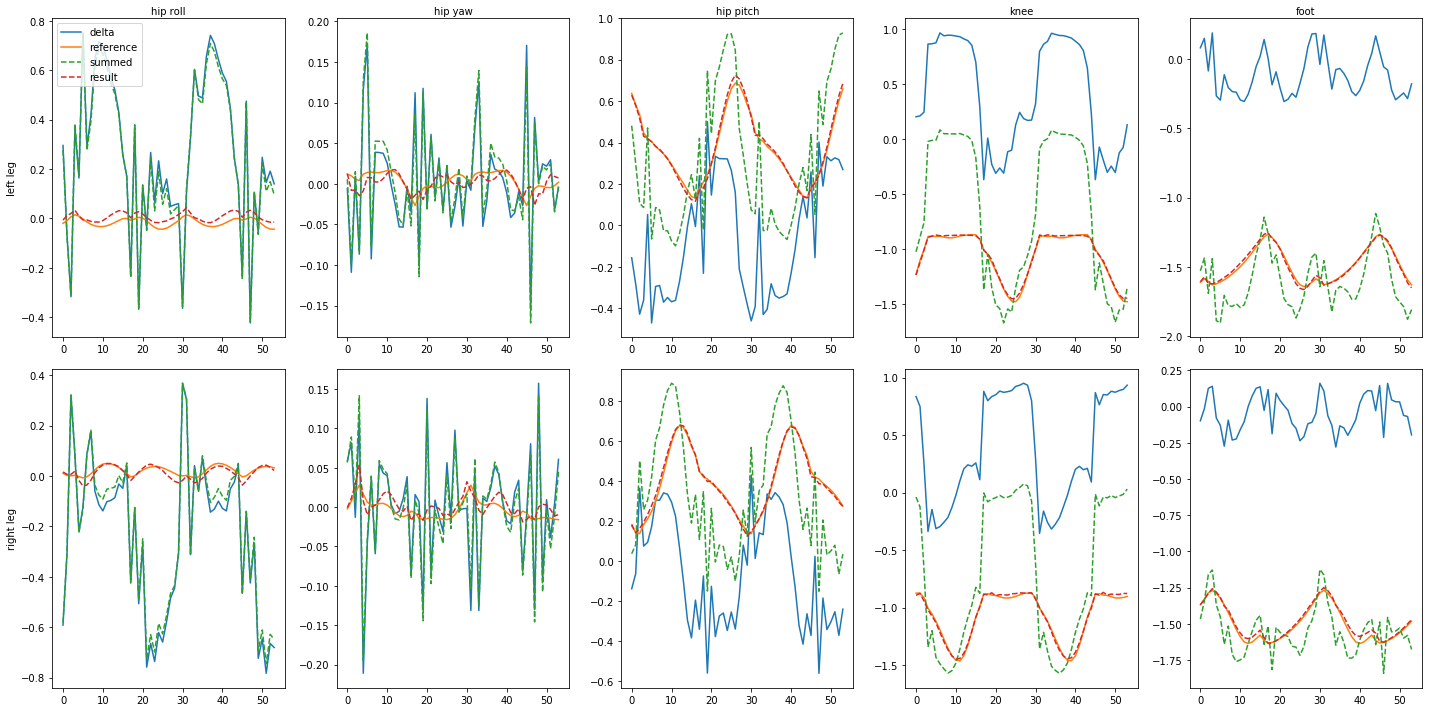

In [4]:
from matplotlib import pyplot as plt

def plot_policy(data, title=None):
    cassie_action = ["hip roll", "hip yaw", "hip pitch", "knee", "foot"]

    # one row for each leg
    plot_rows = 2 
    plot_cols = 10 // 2

    fig, axes = plt.subplots(plot_rows, plot_cols, figsize=(20, 10))

    if title is not None:
        fig.suptitle(title, fontsize=16)
        
    trj_len = len(data["s"])

    for r in range(plot_rows):     # 2 legs
        for c in range(plot_cols): # 5 actions
            a = r * plot_cols + c
            axes[r][c].plot(np.arange(trj_len), data["u_delta"][:, a], "C0", label="delta")
            axes[r][c].plot(np.arange(trj_len), data["u_ref"][:, a], "C1", label="reference")
            axes[r][c].plot(np.arange(trj_len), data["u_delta"][:, a] + data["u_ref"][:, a], "C2--", label="summed")

            axes[r][c].plot(np.arange(trj_len), data["qpos"][:, env.pos_idx][:, a], "C3--", label="result")

            axes[0][c].set_xlabel(cassie_action[c])
            axes[0][c].xaxis.set_label_position('top') 
        axes[r][0].set_ylabel(["left leg", "right leg"][r])
    
    plt.tight_layout()

    if title is not None:
        plt.subplots_adjust(top=0.93)

    axes[0][0].legend(loc='upper left')

data = get_trajectory_data(2*env.phaselen)

plot_policy(data)

Phase portraits for left and right knee angles.

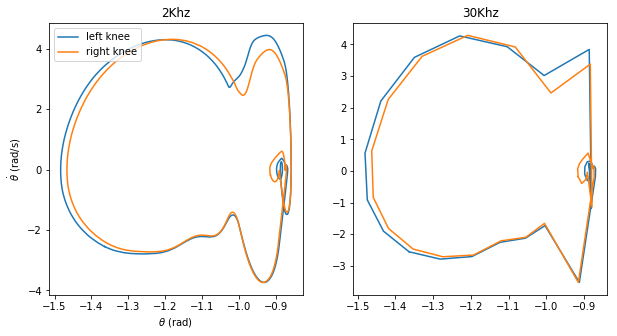

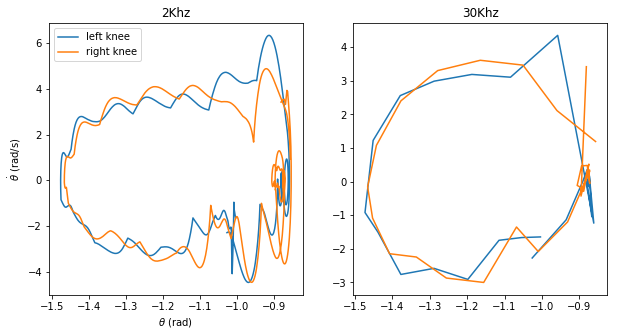

In [5]:
@torch.no_grad()
def plot_phase_portrait():
    qpos = np.copy(traj.qpos)
    qvel = np.copy(traj.qvel)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # down sample trajectory to simrate
    traj_len = qpos.shape[0]
    sub = [t for t in range(traj_len) if t % env.simrate == 0]

    # left leg
    axes[0].plot(qpos[:, 14], qvel[:, 12], label="left knee")
    axes[1].plot(qpos[sub, 14], qvel[sub, 12], label="left knee")
    
    #right leg
    axes[0].plot(qpos[:, 28], qvel[:, 25], label="right knee")
    axes[1].plot(qpos[sub, 28], qvel[sub, 25], label="right knee")

    axes[0].set_ylabel(r"$\dot{\theta}$ (rad/s)")
    axes[0].set_xlabel(r"$\theta$ (rad)")
    
    axes[0].set_title(r"2Khz")
    axes[1].set_title(r"30Khz")
    
    axes[0].legend(loc='upper left')
    
    left_x, left_x_dot = [], []
    right_x, right_x_dot = [], []
    
    # get the full resolution phase portrait
    env.reset()
    for t in range(traj_len):

        if t % env.simrate == 0:
            state = torch.Tensor(env.get_full_state())

            v, action = policy.act(state, True)
            v, action = v.numpy(), action.numpy()

            env.time  += 1
            env.phase += 1

            if env.phase > env.phaselen:
                env.phase = 0
                env.counter += 1

        env.step_simulation(action)
        left_x.append(env.sim.qpos()[14])
        left_x_dot.append(env.sim.qvel()[12])
        
        right_x.append(env.sim.qpos()[28])
        right_x_dot.append(env.sim.qvel()[25])
    
    left_x, left_x_dot = np.array(left_x), np.array(left_x_dot)
    right_x, right_x_dot = np.array(right_x), np.array(right_x_dot)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].plot(left_x, left_x_dot, label="left knee")
    axes[0].plot(right_x, right_x_dot, label="right knee")
        
    axes[1].plot(left_x[sub], left_x_dot[sub], label="left knee")
    axes[1].plot(right_x[sub], right_x_dot[sub], label="right knee")
    
    axes[0].set_ylabel(r"$\dot{\theta}$ (rad/s)")
    axes[0].set_xlabel(r"$\theta$ (rad)")
    
    axes[0].set_title(r"2Khz")
    axes[1].set_title(r"30Khz")
    
    axes[0].legend(loc='upper left')


plot_phase_portrait()

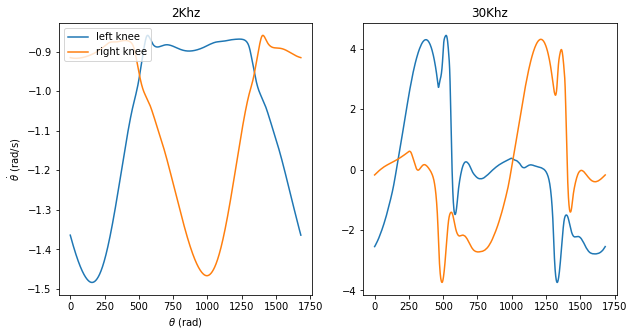

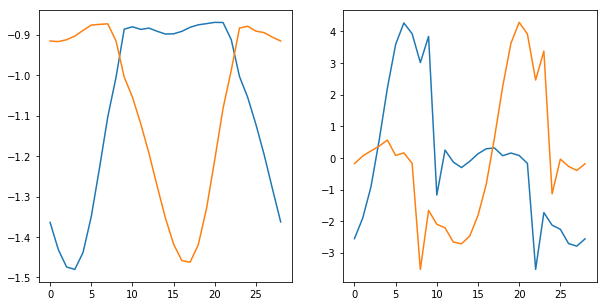

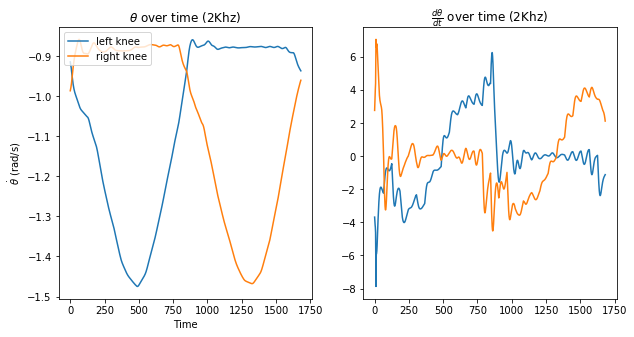

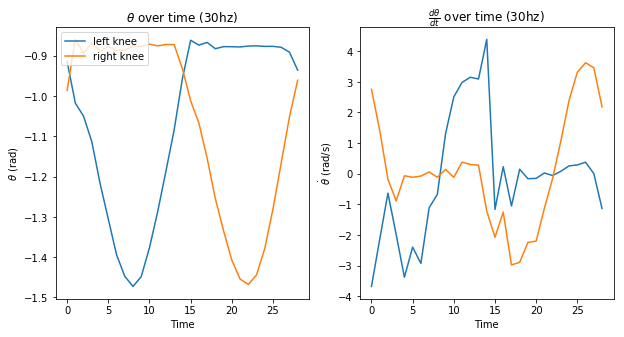

In [27]:
@torch.no_grad()
def plot_phase_states():
    qpos = np.copy(traj.qpos)
    qvel = np.copy(traj.qvel)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # down sample trajectory to simrate
    traj_len = qpos.shape[0]
    sub = [t for t in range(traj_len) if t % env.simrate == 0]

    # full resolution
    axes[0].plot(np.arange(traj_len), qpos[:, 14], label="left knee")
    axes[0].plot(np.arange(traj_len), qpos[:, 28], label="right knee")
    
    axes[1].plot(np.arange(traj_len), qvel[:, 12], label="left knee")
    axes[1].plot(np.arange(traj_len), qvel[:, 25], label="right knee")

    axes[0].set_ylabel(r"$\dot{\theta}$ (rad/s)")
    axes[0].set_xlabel(r"$\theta$ (rad)")
    
    axes[0].set_title(r"2Khz")
    axes[1].set_title(r"30Khz")
    
    axes[0].legend(loc='upper left')
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # downsampled
    axes[0].plot(np.arange(len(sub)), qpos[sub, 14], label="left knee")
    axes[0].plot(np.arange(len(sub)), qpos[sub, 28], label="right knee")
    
    axes[1].plot(np.arange(len(sub)), qvel[sub, 12], label="left knee")
    axes[1].plot(np.arange(len(sub)), qvel[sub, 25], label="right knee")
    
    left_x, left_x_dot = [], []
    right_x, right_x_dot = [], []
    
    # get the full resolution phase portrait
    env.reset()
    for t in range(traj_len):

        if t % env.simrate == 0:
            state = torch.Tensor(env.get_full_state())

            v, action = policy.act(state, True)
            v, action = v.numpy(), action.numpy()

            env.time  += 1
            env.phase += 1

            if env.phase > env.phaselen:
                env.phase = 0
                env.counter += 1

        env.step_simulation(action)
        left_x.append(env.sim.qpos()[14])
        left_x_dot.append(env.sim.qvel()[12])
        
        right_x.append(env.sim.qpos()[28])
        right_x_dot.append(env.sim.qvel()[25])
    
    left_x, left_x_dot = np.array(left_x), np.array(left_x_dot)
    right_x, right_x_dot = np.array(right_x), np.array(right_x_dot)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # full resolution positions
    axes[0].plot(np.arange(traj_len), left_x, label="left knee")
    axes[0].plot(np.arange(traj_len), right_x, label="right knee")
    
    # full resolution velocities
    axes[1].plot(np.arange(traj_len), left_x_dot, label="left knee")
    axes[1].plot(np.arange(traj_len), right_x_dot, label="left knee")

    
    axes[0].set_ylabel(r"$\dot{\theta}$ (rad/s)")
    axes[0].set_xlabel(r"Time")
    
    axes[0].set_title(r"$\theta$ over time (2Khz)")
    axes[1].set_title(r"$\frac{d\theta}{dt}$ over time (2Khz)")
    
    axes[0].legend(loc='upper left')
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # downsampled positions
    axes[0].plot(np.arange(len(sub)), left_x[sub], label="left knee")
    axes[0].plot(np.arange(len(sub)), right_x[sub], label="right knee")
    
    # downsampled velocities
    axes[1].plot(np.arange(len(sub)), left_x_dot[sub], label="left knee")
    axes[1].plot(np.arange(len(sub)), right_x_dot[sub], label="left knee")

    axes[0].set_ylabel(r"$\theta$ (rad)")
    axes[0].set_xlabel(r"Time")
    
    axes[1].set_ylabel(r"$\dot{\theta}$ (rad/s)")
    axes[1].set_xlabel(r"Time")
    
    axes[0].set_title(r"$\theta$ over time (30hz)")
    axes[1].set_title(r"$\frac{d\theta}{dt}$ over time (30hz)")
    
    axes[0].legend(loc='upper left')
    


plot_phase_states()

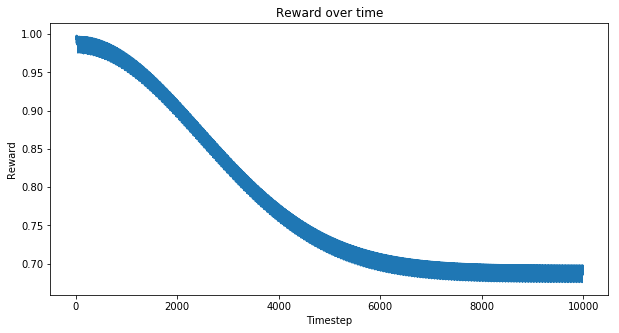

In [6]:
def plot_reward(data):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.gca()
    
    ax.plot(np.arange(len(data["reward"])), data["reward"])
    
    ax.set_ylabel(r"Reward")
    ax.set_xlabel(r"Timestep")
    ax.set_title("Reward over time")

data = get_trajectory_data(10000)
plot_reward(data)

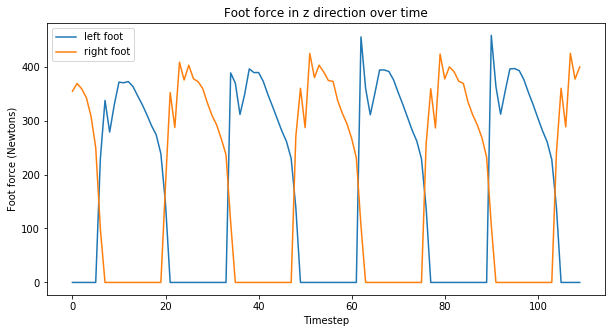

In [7]:
def plot_foot_forces(data):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.gca()
    
    ax.plot(np.arange(len(data["ff_left"])), data["ff_left"], label="left foot")
    ax.plot(np.arange(len(data["ff_right"])), data["ff_right"], label="right foot")
    
    ax.set_ylabel(r"Foot force (Newtons)")
    ax.set_xlabel(r"Timestep")
    ax.set_title("Foot force in z direction over time")
    
    ax.legend(loc='upper left')

data = get_trajectory_data(110)
plot_foot_forces(data)